In [33]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import os
import sys
import pandas as pd
import numpy as np
import quandl
import cvxpy as cvx

In [35]:
sys.path.insert(0, os.path.abspath('..'))
import helium

In [36]:
%matplotlib inline

In [37]:
quandl.ApiConfig.api_key = '8wnB7EcvJm1xEvJjzWBR'

In [38]:
tickers = ['AMZN', 'GOOGL']#, 'TSLA', 'NKE']
start_date='2012-01-01'
end_date='2013-12-31'
returns = pd.DataFrame(dict([(ticker, quandl.get('WIKI/'+ticker, 
                                    start_date=start_date, 
                                    end_date=end_date)['Adj. Close'].pct_change())
                for ticker in tickers]))
returns[["_CASH"]]=quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date)/(250*100)
returns = returns.fillna(method='ffill').iloc[1:]

returns.tail()

,AMZN,GOOGL,_CASH
Date,,,
2013-12-24,-0.009233,-0.002924,0.000003
2013-12-26,0.013001,0.005055,0.000003
2013-12-27,-0.015604,0.000841,0.000003
2013-12-30,-0.011832,-0.007994,0.000003
2013-12-31,0.013778,0.010140,0.000003


In [39]:
rets = returns.rolling(window=250, min_periods=250).mean().shift(1).dropna()
sigmas = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack()

rets.tail()

,AMZN,GOOGL,_CASH
Date,,,
2013-12-24,0.002077,0.001906,0.000002
2013-12-26,0.002045,0.001909,0.000002
2013-12-27,0.002148,0.001965,0.000002
2013-12-30,0.001993,0.001926,0.000002
2013-12-31,0.001843,0.001804,0.000002


In [40]:
cash_ticker = "_CASH"

In [41]:
price_sigma = rets.copy()
price_sigma[:] = 0.

In [42]:
volumes = pd.DataFrame(dict([(ticker, quandl.get('WIKI/'+ticker, 
                                    start_date=start_date, 
                                    end_date=end_date)['Adj. Volume'])
                for ticker in tickers]))

In [43]:
volumes[cash_ticker] = np.finfo(np.float).max

In [44]:
tcost_model=helium.TransactionCost(gamma = 1., 
                                   half_spread=10E-4,
                                   nonlin_coef = 0.,  #1.,
                                   sigmas = price_sigma, 
                                   nonlin_power = 1.5,
                                   volumes = volumes,
                                   asym_coef = 0.)

In [45]:
borrow_costs = rets.copy()
borrow_costs[:] = 1E-4
borrow_costs["_CASH"] = 0.

dividends = rets.copy()
dividends[:] = 0.


hcost_model=helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)

In [46]:
risk_model = helium.BasicRiskCost(5.0, sigmas)

In [47]:
leverage_limit = helium.LeverageLimitConstraint(3.)

In [48]:
holding_init = pd.Series(index=rets.columns, data=0.)
holding_init[cash_ticker] = 100.
holding_init

AMZN       0.0
GOOGL      0.0
_CASH    100.0
dtype: float64

In [49]:
deltas = rets.copy()
deltas[:]  = 0.

In [50]:
r = helium.DefaultRet(rets=rets, deltas = deltas, gamma_decay=None)

In [51]:
spo_policy = helium.SinglePeriodOpt(rets=r,
                                   costs=[],  #, tcost_model, hcost_model
                                   constraints=[]
                                   )

In [52]:
simulator = helium.MarketSimulator(returns, volumes, costs=[], cash_ticker='_CASH')

In [59]:
result = simulator.run(holding_init, policy=spo_policy, start_date='2013-01-03', end_date='2016-12-31')

INFO:root:Backtest started, from 2013-01-03 00:00:00 to 2013-12-31 00:00:00
INFO:root:Getting trades at date: 2013-01-03 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-03 00:00:00
INFO:root:Getting trades at date: 2013-01-04 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-04 00:00:00
INFO:root:Getting trades at date: 2013-01-07 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-07 00:00:00
INFO:root:Getting trades at date: 2013-01-08 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-08 00:00:00


******
QQQ: AMZN       0.0
GOOGL      0.0
_CASH    100.0
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.64589414e-03]
 [  4.37894343e-04]
 [  3.51200000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3519)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.0
GOOGL      0.0
_CASH    100.0
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00032
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00032
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.69804311e-03]
 [  4.22964670e-04]
 [  3.52160000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3521)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.00000
GOOGL      0.00000
_CASH    100.00032
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.0000
GOOGL    

INFO:root:Getting trades at date: 2013-01-09 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-09 00:00:00
INFO:root:Getting trades at date: 2013-01-10 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-10 00:00:00
INFO:root:Getting trades at date: 2013-01-11 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-11 00:00:00
INFO:root:Getting trades at date: 2013-01-14 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-14 00:00:00
INFO:root:Getting trades at date: 2013-01-15 00:00:00



******
QQQ: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00116
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.79497386e-03]
 [  7.56306301e-04]
 [  3.54720000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3527)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.00000
GOOGL      0.00000
_CASH    100.00116
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.0000
GOOGL      0.0000
_CASH    100.0014
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.0000
GOOGL      0.0000
_CASH    100.0014
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.77705025e-03]
 [  7.78217737e-04]
 [  3.55360000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3529)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.0000
GOOGL      0.0000
_CASH    100.0014
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-15 00:00:00
INFO:root:Getting trades at date: 2013-01-16 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-16 00:00:00
INFO:root:Getting trades at date: 2013-01-17 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-17 00:00:00
INFO:root:Getting trades at date: 2013-01-18 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-18 00:00:00
INFO:root:Getting trades at date: 2013-01-22 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-22 00:00:00


Obj: sum_entries(mul_elemwise([[  1.89219193e-03]
 [  6.85834298e-04]
 [  3.57440000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3535)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.00000
GOOGL      0.00000
_CASH    100.00224
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.0000
GOOGL      0.0000
_CASH    100.0026
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.0000
GOOGL      0.0000
_CASH    100.0026
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.80738113e-03]
 [  6.72149324e-04]
 [  3.58400000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3537)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.0000
GOOGL      0.0000
_CASH    100.0026
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00292
dtype: float64
u: AMZN     0.0
GOOGL   

INFO:root:Getting trades at date: 2013-01-23 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-23 00:00:00
INFO:root:Getting trades at date: 2013-01-24 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-24 00:00:00
INFO:root:Getting trades at date: 2013-01-25 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-25 00:00:00


h = AMZN       0.00000
GOOGL      0.00000
_CASH    100.00352
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00384
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00384
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.67933953e-03]
 [  8.17818097e-04]
 [  3.60640000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3545)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.00000
GOOGL      0.00000
_CASH    100.00384
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00416
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00416
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.62898595e-03]
 [  1.06901635e-03]
 [  3.612800

INFO:root:Getting trades at date: 2013-01-28 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-28 00:00:00
INFO:root:Getting trades at date: 2013-01-29 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-29 00:00:00
INFO:root:Getting trades at date: 2013-01-30 00:00:00


h = AMZN       0.00000
GOOGL      0.00000
_CASH    100.00448
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.0000
GOOGL      0.0000
_CASH    100.0048
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.0000
GOOGL      0.0000
_CASH    100.0048
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.72818914e-03]
 [  1.22321454e-03]
 [  3.62400000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3551)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.0000
GOOGL      0.0000
_CASH    100.0048
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00508
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00508
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.57371300e-03]
 [  1.12396365e-03]
 [  3.62560000e-06]],

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-30 00:00:00
INFO:root:Getting trades at date: 2013-01-31 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-01-31 00:00:00
INFO:root:Getting trades at date: 2013-02-01 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-01 00:00:00
INFO:root:Getting trades at date: 2013-02-04 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-04 00:00:00
INFO:root:Getting trades at date: 2013-02-05 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-05 00:00:00
INFO:root:Getting trades at date: 2013-02-06 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-06 00:00:00


******
QQQ: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00536
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.41228084e-03]
 [  1.15547533e-03]
 [  3.62880000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3555)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.00000
GOOGL      0.00000
_CASH    100.00536
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00564
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00564
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.55533761e-03]
 [  1.13951503e-03]
 [  3.63040000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3557)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.00000
GOOGL      0.00000
_CASH    100.00564
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZ

INFO:root:Getting trades at date: 2013-02-07 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-07 00:00:00
INFO:root:Getting trades at date: 2013-02-08 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-08 00:00:00
INFO:root:Getting trades at date: 2013-02-11 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-11 00:00:00
INFO:root:Getting trades at date: 2013-02-12 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-12 00:00:00


h = AMZN       0.00000
GOOGL      0.00000
_CASH    100.00672
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000
GOOGL      0.000
_CASH    100.007
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000
GOOGL      0.000
_CASH    100.007
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.60226127e-03]
 [  1.04632136e-03]
 [  3.62400000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3567)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000
GOOGL      0.000
_CASH    100.007
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00728
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00728
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.54389053e-03]
 [  1.04564915e-03]
 [  3.62080000e-06]], [[ 0.]
 

INFO:root:Getting trades at date: 2013-02-13 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-13 00:00:00
INFO:root:Getting trades at date: 2013-02-14 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-14 00:00:00
INFO:root:Getting trades at date: 2013-02-15 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-15 00:00:00
INFO:root:Getting trades at date: 2013-02-19 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-19 00:00:00
INFO:root:Getting trades at date: 2013-02-20 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-20 00:00:00


h = AMZN       0.00000
GOOGL      0.00000
_CASH    100.00792
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00828
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00828
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.38936350e-03]
 [  1.06507531e-03]
 [  3.61440000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3575)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.00000
GOOGL      0.00000
_CASH    100.00828
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00868
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.00000
GOOGL      0.00000
_CASH    100.00868
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.56194303e-03]
 [  1.09208480e-03]
 [  3.611200

INFO:root:Getting trades at date: 2013-02-21 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-21 00:00:00
INFO:root:Getting trades at date: 2013-02-22 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-22 00:00:00
INFO:root:Getting trades at date: 2013-02-25 00:00:00


h = AMZN       0.00
GOOGL      0.00
_CASH    100.01
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.010481
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.010481
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.70704576e-03]
 [  1.11394449e-03]
 [  3.62240000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3585)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.010481
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.011001
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.011001
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.73685938e-03]
 [  1.16891937e-03]
 [  3.

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-25 00:00:00
INFO:root:Getting trades at date: 2013-02-26 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-26 00:00:00
INFO:root:Getting trades at date: 2013-02-27 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-27 00:00:00


AMZN       0.000000
GOOGL      0.000000
_CASH    100.011521
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.76647300e-03]
 [  1.20197747e-03]
 [  3.63520000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3589)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.011521
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.012001
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.012001
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.67746555e-03]
 [  1.13224930e-03]
 [  3.63840000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3591)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.012001
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: 

INFO:root:Getting trades at date: 2013-02-28 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-02-28 00:00:00
INFO:root:Getting trades at date: 2013-03-01 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-01 00:00:00
INFO:root:Getting trades at date: 2013-03-04 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-04 00:00:00


h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.012561
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.013001
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.013001
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.62493200e-03]
 [  1.12212574e-03]
 [  3.64320000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3595)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.013001
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.013441
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.013441
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.72987562e-03]
 [  1.13013327

INFO:root:Getting trades at date: 2013-03-05 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-05 00:00:00
INFO:root:Getting trades at date: 2013-03-06 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-06 00:00:00
INFO:root:Getting trades at date: 2013-03-07 00:00:00


******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.014321
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.87171069e-03]
 [  1.21156876e-03]
 [  3.65920000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3601)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.014321
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.014641
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.014641
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.88661643e-03]
 [  1.33990110e-03]
 [  3.65920000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3603)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.014641
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: floa

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-07 00:00:00
INFO:root:Getting trades at date: 2013-03-08 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-08 00:00:00
INFO:root:Getting trades at date: 2013-03-11 00:00:00


AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.015041
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.015441
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.015441
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.78419061e-03]
 [  1.35962480e-03]
 [  3.66560000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3607)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.015441
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.015841
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.015841
dtype: float64
Obj

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-11 00:00:00
INFO:root:Getting trades at date: 2013-03-12 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-12 00:00:00
INFO:root:Getting trades at date: 2013-03-13 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-13 00:00:00
INFO:root:Getting trades at date: 2013-03-14 00:00:00



constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.015841
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.016241
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.016241
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.73222039e-03]
 [  1.41348186e-03]
 [  3.67040000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3611)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.016241
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.016641
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.016641
d

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-14 00:00:00
INFO:root:Getting trades at date: 2013-03-15 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-15 00:00:00
INFO:root:Getting trades at date: 2013-03-18 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-18 00:00:00
INFO:root:Getting trades at date: 2013-03-19 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-19 00:00:00


******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.017001
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.78300190e-03]
 [  1.25168264e-03]
 [  3.67360000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3615)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.017001
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.017401
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.017401
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.69739621e-03]
 [  1.24500061e-03]
 [  3.67520000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3617)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.017401
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: floa

INFO:root:Getting trades at date: 2013-03-20 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-20 00:00:00
INFO:root:Getting trades at date: 2013-03-21 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-21 00:00:00
INFO:root:Getting trades at date: 2013-03-22 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-22 00:00:00


h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.018042
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.018322
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.018322
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.48416387e-03]
 [  1.07948172e-03]
 [  3.66880000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3623)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.018322
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.018602
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.018602
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.35087415e-03]
 [  1.09927694

INFO:root:Getting trades at date: 2013-03-25 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-25 00:00:00
INFO:root:Getting trades at date: 2013-03-26 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-26 00:00:00
INFO:root:Getting trades at date: 2013-03-27 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-03-27 00:00:00
INFO:root:Getting trades at date: 2013-03-28 00:00:00
ERROR:root:The problem is unbounded


u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.019162
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.35775319e-03]
 [  9.98746081e-04]
 [  3.65920000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3629)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.019162
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.019482
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.019482
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.27601982e-03]
 [  1.01686120e-03]
 [  3.65920000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3631)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.019482
dtype: float

INFO:root:Propagating portfolio at time 2013-03-28 00:00:00
INFO:root:Getting trades at date: 2013-04-01 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-01 00:00:00
INFO:root:Getting trades at date: 2013-04-02 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-02 00:00:00
INFO:root:Getting trades at date: 2013-04-03 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-03 00:00:00
INFO:root:Getting trades at date: 2013-04-04 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-04 00:00:00
INFO:root:Getting trades at date: 2013-04-05 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-05 00:00:00



******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.020122
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.020402
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.020402
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.30974364e-03]
 [  8.58564620e-04]
 [  3.65280000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3637)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.020402
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.020722
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.020722
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.16789300e-03]
 [  9.

INFO:root:Getting trades at date: 2013-04-08 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-08 00:00:00
INFO:root:Getting trades at date: 2013-04-09 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-09 00:00:00
INFO:root:Getting trades at date: 2013-04-10 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-10 00:00:00
INFO:root:Getting trades at date: 2013-04-11 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-11 00:00:00


h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.021802
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.021802
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.28428665e-03]
 [  9.30364778e-04]
 [  3.64800000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3647)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.021802
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.022082
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.022082
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.33036790e-03]
 [  9.06299849e-04]
 [  3.64640000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3649)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64


INFO:root:Getting trades at date: 2013-04-12 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-12 00:00:00
INFO:root:Getting trades at date: 2013-04-15 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-15 00:00:00
INFO:root:Getting trades at date: 2013-04-16 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-16 00:00:00
INFO:root:Getting trades at date: 2013-04-17 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-17 00:00:00
INFO:root:Getting trades at date: 2013-04-18 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-18 00:00:00



u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.022883
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.022883
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.62916485e-03]
 [  9.62799246e-04]
 [  3.63520000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3655)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.022883
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.023123
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.023123
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.61604888e-03]
 [  8.66418535e-04]
 [  3.63040000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3657)) + -0
constraints

INFO:root:Getting trades at date: 2013-04-19 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-19 00:00:00
INFO:root:Getting trades at date: 2013-04-22 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-22 00:00:00
INFO:root:Getting trades at date: 2013-04-23 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-23 00:00:00
INFO:root:Getting trades at date: 2013-04-24 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-24 00:00:00
INFO:root:Getting trades at date: 2013-04-25 00:00:00
ERROR:root:The problem is unbounded



h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.024043
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.024043
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.40803551e-03]
 [  1.01599323e-03]
 [  3.61600000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3665)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.024043
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.024243
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.024243
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.42128458e-03]
 [  1.24699603e-03]
 [  3.61280000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3667)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64

INFO:root:Propagating portfolio at time 2013-04-25 00:00:00
INFO:root:Getting trades at date: 2013-04-26 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-26 00:00:00
INFO:root:Getting trades at date: 2013-04-29 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-29 00:00:00
INFO:root:Getting trades at date: 2013-04-30 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-04-30 00:00:00
INFO:root:Getting trades at date: 2013-05-01 00:00:00


h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.024883
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.025083
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.025083
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.56814286e-03]
 [  1.22374062e-03]
 [  3.59200000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3675)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.025083
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.025283
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.025283
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.24621661e-03]
 [  1.14805028

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-01 00:00:00
INFO:root:Getting trades at date: 2013-05-02 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-02 00:00:00



QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.025683
dtype: float64
Obj: sum_entries(mul_elemwise([[  5.12942015e-04]
 [  1.33207578e-03]
 [  3.57120000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3681)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.025683
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.025923
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.025923
dtype: float64
Obj: sum_entries(mul_elemwise([[  4.57085012e-04]
 [  1.31477013e-03]
 [  3.56640000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3683)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.025923
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_

INFO:root:Getting trades at date: 2013-05-03 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-03 00:00:00
INFO:root:Getting trades at date: 2013-05-06 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-06 00:00:00
INFO:root:Getting trades at date: 2013-05-07 00:00:00


******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.026123
dtype: float64
Obj: sum_entries(mul_elemwise([[  5.23046332e-04]
 [  1.34079876e-03]
 [  3.56160000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3685)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.026123
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.026323
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.026323
dtype: float64
Obj: sum_entries(mul_elemwise([[  6.24055732e-04]
 [  1.39370682e-03]
 [  3.55520000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3687)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.026323
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: floa

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-07 00:00:00
INFO:root:Getting trades at date: 2013-05-08 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-08 00:00:00
INFO:root:Getting trades at date: 2013-05-09 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-09 00:00:00
INFO:root:Getting trades at date: 2013-05-10 00:00:00


AMZN       0.000000
GOOGL      0.000000
_CASH    100.026483
dtype: float64
Obj: sum_entries(mul_elemwise([[  6.83122836e-04]
 [  1.56055529e-03]
 [  3.55040000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3689)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.026483
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.026644
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.026644
dtype: float64
Obj: sum_entries(mul_elemwise([[  6.93669685e-04]
 [  1.46960708e-03]
 [  3.54080000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3691)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.026644
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: 

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-10 00:00:00
INFO:root:Getting trades at date: 2013-05-13 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-13 00:00:00
INFO:root:Getting trades at date: 2013-05-14 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-14 00:00:00
INFO:root:Getting trades at date: 2013-05-15 00:00:00


******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.026964
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.70119206e-04]
 [  1.52554961e-03]
 [  3.52480000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3695)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.026964
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.027124
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.027124
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.56917936e-04]
 [  1.53609614e-03]
 [  3.51520000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3697)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.027124
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: floa

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-15 00:00:00
INFO:root:Getting trades at date: 2013-05-16 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-16 00:00:00
INFO:root:Getting trades at date: 2013-05-17 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-17 00:00:00
INFO:root:Getting trades at date: 2013-05-20 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-20 00:00:00
INFO:root:Getting trades at date: 2013-05-21 00:00:00
ERROR:root:The problem is unbounded


******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.027524
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.94018841e-04]
 [  1.63052719e-03]
 [  3.49920000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3701)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.027524
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.027684
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.027684
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.41436856e-04]
 [  1.71325736e-03]
 [  3.49120000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3703)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.027684
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: floa

INFO:root:Propagating portfolio at time 2013-05-21 00:00:00
INFO:root:Getting trades at date: 2013-05-22 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-22 00:00:00
INFO:root:Getting trades at date: 2013-05-23 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-23 00:00:00


h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.028164
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.028324
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.028324
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.87674595e-04]
 [  1.64936419e-03]
 [  3.45760000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3711)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.028324
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.028484
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.028484
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.50880018e-04]
 [  1.65865818

INFO:root:Getting trades at date: 2013-05-24 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-24 00:00:00
INFO:root:Getting trades at date: 2013-05-28 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-28 00:00:00
INFO:root:Getting trades at date: 2013-05-29 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-29 00:00:00
INFO:root:Getting trades at date: 2013-05-30 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-30 00:00:00



u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.028684
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.97011278e-04]
 [  1.57118453e-03]
 [  3.44320000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3715)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.028684
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.028844
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.028844
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.33649775e-04]
 [  1.56634161e-03]
 [  3.43360000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3717)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.028844
dtype: floa

INFO:root:Getting trades at date: 2013-05-31 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-05-31 00:00:00
INFO:root:Getting trades at date: 2013-06-03 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-03 00:00:00
INFO:root:Getting trades at date: 2013-06-04 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-04 00:00:00
INFO:root:Getting trades at date: 2013-06-05 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-05 00:00:00
INFO:root:Getting trades at date: 2013-06-06 00:00:00



h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.029404
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.029404
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.12325359e-03]
 [  1.65771251e-03]
 [  3.41600000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3723)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.029404
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.029564
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.029564
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.08842863e-03]
 [  1.70993287e-03]
 [  3.41120000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3725)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-06 00:00:00
INFO:root:Getting trades at date: 2013-06-07 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-07 00:00:00
INFO:root:Getting trades at date: 2013-06-10 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-10 00:00:00
INFO:root:Getting trades at date: 2013-06-11 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-11 00:00:00
INFO:root:Getting trades at date: 2013-06-12 00:00:00



QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.030124
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.04987951e-03]
 [  1.72820396e-03]
 [  3.39680000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3731)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.030124
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.030325
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.030325
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.76650312e-04]
 [  1.67994172e-03]
 [  3.39040000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3733)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.030325
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-12 00:00:00
INFO:root:Getting trades at date: 2013-06-13 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-13 00:00:00
INFO:root:Getting trades at date: 2013-06-14 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-14 00:00:00
INFO:root:Getting trades at date: 2013-06-17 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-17 00:00:00


QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.030885
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.10360549e-03]
 [  1.83378740e-03]
 [  3.36960000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3739)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.030885
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.031085
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.031085
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.05981097e-03]
 [  1.82211140e-03]
 [  3.36160000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3741)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.031085
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_p

INFO:root:Getting trades at date: 2013-06-18 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-18 00:00:00
INFO:root:Getting trades at date: 2013-06-19 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-19 00:00:00
INFO:root:Getting trades at date: 2013-06-20 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-20 00:00:00
INFO:root:Getting trades at date: 2013-06-21 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-21 00:00:00


******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.031685
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.11749140e-03]
 [  1.89130447e-03]
 [  3.33760000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3747)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.031685
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.031885
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.031885
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.09176151e-03]
 [  1.91123810e-03]
 [  3.32960000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3749)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.031885
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: floa

INFO:root:Getting trades at date: 2013-06-24 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-24 00:00:00
INFO:root:Getting trades at date: 2013-06-25 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-25 00:00:00
INFO:root:Getting trades at date: 2013-06-26 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-26 00:00:00
INFO:root:Getting trades at date: 2013-06-27 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-27 00:00:00


******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.032485
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.00888366e-03]
 [  1.86149698e-03]
 [  3.31040000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3755)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.032485
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.032725
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.032725
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.39900627e-04]
 [  1.76654118e-03]
 [  3.30560000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3757)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.032725
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: floa

INFO:root:Getting trades at date: 2013-06-28 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-06-28 00:00:00
INFO:root:Getting trades at date: 2013-07-01 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-01 00:00:00
INFO:root:Getting trades at date: 2013-07-02 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-02 00:00:00
INFO:root:Getting trades at date: 2013-07-03 00:00:00
ERROR:root:The problem is unbounded


h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.033205
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.033446
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.033446
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.78808929e-04]
 [  1.81442666e-03]
 [  3.28800000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3763)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.033446
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.033606
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.033606
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.05723825e-03]
 [  1.86453737

INFO:root:Propagating portfolio at time 2013-07-03 00:00:00
INFO:root:Getting trades at date: 2013-07-05 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-05 00:00:00
INFO:root:Getting trades at date: 2013-07-08 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-08 00:00:00
INFO:root:Getting trades at date: 2013-07-09 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-09 00:00:00
INFO:root:Getting trades at date: 2013-07-10 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-10 00:00:00
INFO:root:Getting trades at date: 2013-07-11 00:00:00



******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.033886
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.034086
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.034086
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.00020727e-03]
 [  1.72705669e-03]
 [  3.25440000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3771)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.034086
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.034246
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.034246
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.06930534e-03]
 [  1.

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-11 00:00:00
INFO:root:Getting trades at date: 2013-07-12 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-12 00:00:00
INFO:root:Getting trades at date: 2013-07-15 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-15 00:00:00
INFO:root:Getting trades at date: 2013-07-16 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-16 00:00:00
INFO:root:Getting trades at date: 2013-07-17 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-17 00:00:00
INFO:root:Getting trades at date: 2013-07-18 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-18 00:00:00
INFO:root:Getting trades at date: 2013-07-19 00:00:00


******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.034766
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.29317677e-03]
 [  1.85570791e-03]
 [  3.22720000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3779)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.034766
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.034926
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.034926
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.41406664e-03]
 [  1.99089344e-03]
 [  3.21760000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3781)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.034926
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: floa

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-19 00:00:00
INFO:root:Getting trades at date: 2013-07-22 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-22 00:00:00
INFO:root:Getting trades at date: 2013-07-23 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-23 00:00:00
INFO:root:Getting trades at date: 2013-07-24 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-24 00:00:00
INFO:root:Getting trades at date: 2013-07-25 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-25 00:00:00
INFO:root:Getting trades at date: 2013-07-26 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-26 00:00:00
INFO:root:Getting trades at date: 2013-07-29 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-29 00:00:00


******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.035606
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.49038650e-03]
 [  1.88253643e-03]
 [  3.16640000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3791)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.035606
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.035726
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.035726
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.34509594e-03]
 [  1.73596717e-03]
 [  3.15680000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3793)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.035726
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: floa

INFO:root:Getting trades at date: 2013-07-30 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-30 00:00:00
INFO:root:Getting trades at date: 2013-07-31 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-07-31 00:00:00
INFO:root:Getting trades at date: 2013-08-01 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-01 00:00:00
INFO:root:Getting trades at date: 2013-08-02 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-02 00:00:00
INFO:root:Getting trades at date: 2013-08-05 00:00:00
ERROR:root:The problem is unbounded


h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.036287
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.036407
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.036407
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.15270422e-03]
 [  1.39489093e-03]
 [  3.08640000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3805)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.036407
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.036567
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.036567
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.12521618e-03]
 [  1.45086491

INFO:root:Propagating portfolio at time 2013-08-05 00:00:00
INFO:root:Getting trades at date: 2013-08-06 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-06 00:00:00
INFO:root:Getting trades at date: 2013-08-07 00:00:00
ERROR:root:The problem is unbounded


AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.037047
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.037247
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.037247
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.12508149e-03]
 [  1.45672001e-03]
 [  3.04000000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3815)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.037247
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.037407
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.037407
dtype: float64
Obj

INFO:root:Propagating portfolio at time 2013-08-07 00:00:00
INFO:root:Getting trades at date: 2013-08-08 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-08 00:00:00
INFO:root:Getting trades at date: 2013-08-09 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-09 00:00:00
INFO:root:Getting trades at date: 2013-08-12 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-12 00:00:00


AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.037407
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.037607
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.037607
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.04356918e-03]
 [  1.39794288e-03]
 [  3.02080000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3819)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.037607
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.037807
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.037807
dtype: float64
Obj

INFO:root:Getting trades at date: 2013-08-13 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-13 00:00:00
INFO:root:Getting trades at date: 2013-08-14 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-14 00:00:00
INFO:root:Getting trades at date: 2013-08-15 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-15 00:00:00
INFO:root:Getting trades at date: 2013-08-16 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-16 00:00:00
INFO:root:Getting trades at date: 2013-08-19 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-19 00:00:00
INFO:root:Getting trades at date: 2013-08-20 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-20 00:00:00


h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.038007
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.038247
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.038247
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.10540569e-03]
 [  1.36575394e-03]
 [  2.99520000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3825)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.038247
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.038487
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.038487
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.07406203e-03]
 [  1.23429895

INFO:root:Getting trades at date: 2013-08-21 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-21 00:00:00
INFO:root:Getting trades at date: 2013-08-22 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-22 00:00:00
INFO:root:Getting trades at date: 2013-08-23 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-23 00:00:00
INFO:root:Getting trades at date: 2013-08-26 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-26 00:00:00
INFO:root:Getting trades at date: 2013-08-27 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-27 00:00:00
INFO:root:Getting trades at date: 2013-08-28 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-28 00:00:00
INFO:root:Getting trades at date: 2013-08-29 00:00:00
ERROR:root:The problem is unbounded
INFO:root:

u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.039488
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.45043572e-04]
 [  1.06904126e-03]
 [  2.94880000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3837)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.039488
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.039648
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.039648
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.24910788e-04]
 [  1.12281817e-03]
 [  2.93760000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3839)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.039648
dtype: float

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-08-30 00:00:00
INFO:root:Getting trades at date: 2013-09-03 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-03 00:00:00
INFO:root:Getting trades at date: 2013-09-04 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-04 00:00:00
INFO:root:Getting trades at date: 2013-09-05 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-05 00:00:00
INFO:root:Getting trades at date: 2013-09-06 00:00:00


******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.040448
dtype: float64
Obj: sum_entries(mul_elemwise([[  6.90745950e-04]
 [  9.48836781e-04]
 [  2.86560000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3851)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.040448
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.040568
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.040568
dtype: float64
Obj: sum_entries(mul_elemwise([[  6.63057274e-04]
 [  9.45752199e-04]
 [  2.85440000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3853)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.040568
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: floa

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-06 00:00:00
INFO:root:Getting trades at date: 2013-09-09 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-09 00:00:00
INFO:root:Getting trades at date: 2013-09-10 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-10 00:00:00
INFO:root:Getting trades at date: 2013-09-11 00:00:00



QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.040808
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.47451198e-04]
 [  1.10363044e-03]
 [  2.81600000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3859)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.040808
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.040888
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.040888
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.87561163e-04]
 [  9.93955267e-04]
 [  2.80160000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3861)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.040888
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-11 00:00:00
INFO:root:Getting trades at date: 2013-09-12 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-12 00:00:00
INFO:root:Getting trades at date: 2013-09-13 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-13 00:00:00
INFO:root:Getting trades at date: 2013-09-16 00:00:00
ERROR:root:The problem is unbounded


******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.041048
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.56452589e-04]
 [  1.02713704e-03]
 [  2.77440000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3865)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.041048
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.041128
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.041128
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.68957526e-04]
 [  1.10996007e-03]
 [  2.76160000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3867)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.041128
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: floa

INFO:root:Propagating portfolio at time 2013-09-16 00:00:00
INFO:root:Getting trades at date: 2013-09-17 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-17 00:00:00
INFO:root:Getting trades at date: 2013-09-18 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-18 00:00:00


AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.041208
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.041288
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.041288
dtype: float64
Obj: sum_entries(mul_elemwise([[  6.33649500e-04]
 [  9.71400927e-04]
 [  2.71840000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3873)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.041288
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.041328
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.041328
dtype: float64
Obj

INFO:root:Getting trades at date: 2013-09-19 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-19 00:00:00
INFO:root:Getting trades at date: 2013-09-20 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-20 00:00:00
INFO:root:Getting trades at date: 2013-09-23 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-23 00:00:00
INFO:root:Getting trades at date: 2013-09-24 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-24 00:00:00
INFO:root:Getting trades at date: 2013-09-25 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-25 00:00:00
INFO:root:Getting trades at date: 2013-09-26 00:00:00


h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.041328
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.041368
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.041368
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.85072983e-04]
 [  9.93201573e-04]
 [  2.68800000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3877)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.041368
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.041409
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.041409
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.40111594e-04]
 [  9.20026113

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-26 00:00:00
INFO:root:Getting trades at date: 2013-09-27 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-27 00:00:00
INFO:root:Getting trades at date: 2013-09-30 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-09-30 00:00:00
INFO:root:Getting trades at date: 2013-10-01 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-01 00:00:00
INFO:root:Getting trades at date: 2013-10-02 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-02 00:00:00
INFO:root:Getting trades at date: 2013-10-03 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-03 00:00:00
INFO:root:Getting trades at date: 2013-10-04 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-04 00:00:00
INFO


QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.041689
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.91441349e-04]
 [  7.07310145e-04]
 [  2.61280000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3887)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.041689
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.041689
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.041689
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.10562878e-03]
 [  6.88637316e-04]
 [  2.59520000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3889)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.041689
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_

INFO:root:Getting trades at date: 2013-10-08 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-08 00:00:00
INFO:root:Getting trades at date: 2013-10-09 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-09 00:00:00
INFO:root:Getting trades at date: 2013-10-10 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-10 00:00:00
INFO:root:Getting trades at date: 2013-10-11 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-11 00:00:00
INFO:root:Getting trades at date: 2013-10-14 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-14 00:00:00
INFO:root:Getting trades at date: 2013-10-15 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-15 00:00:00
INFO:root:Getting trades at date: 2013-10-16 00:00:00
ERROR:root:The problem is unbounded
INFO:root:


h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.042369
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.042369
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.64244160e-04]
 [  5.57304687e-04]
 [  2.51520000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3903)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.042369
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.042569
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.042569
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.68000406e-04]
 [  5.52654412e-04]
 [  2.50560000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3905)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64

INFO:root:Getting trades at date: 2013-10-17 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-17 00:00:00
INFO:root:Getting trades at date: 2013-10-18 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-18 00:00:00


h_plus: AMZN       0.00000
GOOGL      0.00000
_CASH    100.04457
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.00000
GOOGL      0.00000
_CASH    100.04457
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.10284378e-03]
 [  8.25397832e-04]
 [  2.48800000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3917)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.00000
GOOGL      0.00000
_CASH    100.04457
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.00000
GOOGL      0.00000
_CASH    100.04477
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.00000
GOOGL      0.00000
_CASH    100.04477
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.04823995e-03]
 [  7.26307079e-04]
 [  2.47840000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3919)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN

INFO:root:Getting trades at date: 2013-10-21 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-21 00:00:00
INFO:root:Getting trades at date: 2013-10-22 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-22 00:00:00
INFO:root:Getting trades at date: 2013-10-23 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-23 00:00:00
INFO:root:Getting trades at date: 2013-10-24 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-24 00:00:00
INFO:root:Getting trades at date: 2013-10-25 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-25 00:00:00
INFO:root:Getting trades at date: 2013-10-28 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-28 00:00:00
INFO:root:Getting trades at date: 2013-10-29 00:00:00


h_plus: AMZN       0.00000
GOOGL      0.00000
_CASH    100.04493
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.00000
GOOGL      0.00000
_CASH    100.04493
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.32466320e-03]
 [  1.59840695e-03]
 [  2.46880000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3921)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.00000
GOOGL      0.00000
_CASH    100.04493
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.00000
GOOGL      0.00000
_CASH    100.04509
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.00000
GOOGL      0.00000
_CASH    100.04509
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.37360332e-03]
 [  1.64236169e-03]
 [  2.45920000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3923)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-29 00:00:00
INFO:root:Getting trades at date: 2013-10-30 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-30 00:00:00
INFO:root:Getting trades at date: 2013-10-31 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-10-31 00:00:00
INFO:root:Getting trades at date: 2013-11-01 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-01 00:00:00
INFO:root:Getting trades at date: 2013-11-04 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-04 00:00:00
INFO:root:Getting trades at date: 2013-11-05 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-05 00:00:00
INFO:root:Getting trades at date: 2013-11-06 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-06 00:00:00
INFO

QQQ: AMZN       0.00000
GOOGL      0.00000
_CASH    100.04585
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.77996385e-03]
 [  1.72921357e-03]
 [  2.40160000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3933)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.00000
GOOGL      0.00000
_CASH    100.04585
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.046011
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.046011
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.92044079e-03]
 [  1.78242049e-03]
 [  2.39040000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3935)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.046011
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: A

INFO:root:Getting trades at date: 2013-11-08 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-08 00:00:00
INFO:root:Getting trades at date: 2013-11-11 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-11 00:00:00
INFO:root:Getting trades at date: 2013-11-12 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-12 00:00:00



h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.047291
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.047291
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.81902425e-03]
 [  1.77228487e-03]
 [  2.33280000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3949)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.047291
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.047531
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.047531
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.89478516e-03]
 [  1.78703550e-03]
 [  2.32800000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3951)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64

INFO:root:Getting trades at date: 2013-11-13 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-13 00:00:00
INFO:root:Getting trades at date: 2013-11-14 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-14 00:00:00
INFO:root:Getting trades at date: 2013-11-15 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-15 00:00:00
INFO:root:Getting trades at date: 2013-11-18 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-18 00:00:00
INFO:root:Getting trades at date: 2013-11-19 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-19 00:00:00
INFO:root:Getting trades at date: 2013-11-20 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-20 00:00:00


******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.048091
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.94864882e-03]
 [  1.85092698e-03]
 [  2.31680000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3955)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.048091
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.048412
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.048412
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.06738863e-03]
 [  1.96515005e-03]
 [  2.31680000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3957)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.048412
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: floa

INFO:root:Getting trades at date: 2013-11-21 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-21 00:00:00
INFO:root:Getting trades at date: 2013-11-22 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-22 00:00:00
INFO:root:Getting trades at date: 2013-11-25 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-25 00:00:00
INFO:root:Getting trades at date: 2013-11-26 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-26 00:00:00
INFO:root:Getting trades at date: 2013-11-27 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-27 00:00:00
INFO:root:Getting trades at date: 2013-11-29 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-11-29 00:00:00
INFO:root:Getting trades at date: 2013-12-02 00:00:00
ERROR:root:The problem is unbounded
INFO:root:

u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.050052
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.050052
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.80206639e-03]
 [  1.79755538e-03]
 [  2.31360000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3967)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.050052
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.050333
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.050333
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.80975731e-03]
 [  1.88440897e-03]
 [  2.30880000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3969)) + -0
constraints:

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-03 00:00:00
INFO:root:Getting trades at date: 2013-12-04 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-04 00:00:00
INFO:root:Getting trades at date: 2013-12-05 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-05 00:00:00
INFO:root:Getting trades at date: 2013-12-06 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-06 00:00:00
INFO:root:Getting trades at date: 2013-12-09 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-09 00:00:00
INFO:root:Getting trades at date: 2013-12-10 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-10 00:00:00
INFO:root:Getting trades at date: 2013-12-11 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-11 00:00:00



Obj: sum_entries(mul_elemwise([[  1.91303621e-03]
 [  1.78481979e-03]
 [  2.28160000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3981)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.051933
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.052174
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.052174
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.81181832e-03]
 [  1.79877287e-03]
 [  2.27520000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3983)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.052174
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.052414
dtype: float64

INFO:root:Getting trades at date: 2013-12-12 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-12 00:00:00
INFO:root:Getting trades at date: 2013-12-13 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-13 00:00:00
INFO:root:Getting trades at date: 2013-12-16 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-16 00:00:00
INFO:root:Getting trades at date: 2013-12-17 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-17 00:00:00
INFO:root:Getting trades at date: 2013-12-18 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-18 00:00:00
INFO:root:Getting trades at date: 2013-12-19 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-19 00:00:00
INFO:root:Getting trades at date: 2013-12-20 00:00:00
ERROR:root:The problem is unbounded
INFO:root:


u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.053734
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.82839818e-03]
 [  1.80308615e-03]
 [  2.25920000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3995)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.053734
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.054015
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.054015
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.85135616e-03]
 [  1.78006382e-03]
 [  2.26400000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var3997)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.054015
dtype: floa

ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-23 00:00:00
INFO:root:Getting trades at date: 2013-12-24 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-24 00:00:00
INFO:root:Getting trades at date: 2013-12-26 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-26 00:00:00
INFO:root:Getting trades at date: 2013-12-27 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-27 00:00:00
INFO:root:Getting trades at date: 2013-12-30 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-30 00:00:00
INFO:root:Getting trades at date: 2013-12-31 00:00:00
ERROR:root:The problem is unbounded
INFO:root:Propagating portfolio at time 2013-12-31 00:00:00



QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.055655
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.91549193e-03]
 [  1.84976048e-03]
 [  2.27520000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var4009)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.055655
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_plus: AMZN       0.000000
GOOGL      0.000000
_CASH    100.055936
dtype: float64
u: AMZN     0.0
GOOGL    0.0
_CASH   -0.0
dtype: float64
******
QQQ: AMZN       0.000000
GOOGL      0.000000
_CASH    100.055936
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.07714330e-03]
 [  1.90593716e-03]
 [  2.27200000e-06]], [[ 0.]
 [ 0.]
 [ 1.]] + var4011)) + -0
constraints: []
AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
******
h = AMZN       0.000000
GOOGL      0.000000
_CASH    100.055936
dtype: float64
u = AMZN     0.0
GOOGL    0.0
_CASH    0.0
dtype: float64
h_

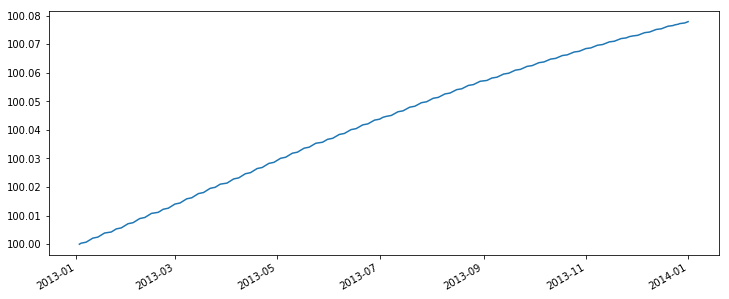

In [22]:
result.v.plot(figsize=(12,5))

In [23]:
1.0352160000e-06*100

0.0001035216